## Project Reinforcement Learning 

Group 7 - Willem Huijzer, Joris Holshuijsen, Max Feucht


In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from evaluate import Evaluation
from agent import DDQNAgent

import gym_env

seed = 2705

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(


### Setting up the environment:

- 50kWh of usable capacity 
- 90% efficiency of the battery (both ways)
- The maximum power available is 25kW (both ways - pertains to charging and discharging. One hour, we charge and discharge 25kWh) 
- Prices are in MWh! --> Rescale
- Electricity is sold at the spot market price
- Electricity is bought at twice the price to pay for the transmission costs and various taxes.
- Only data up to the current time step available
- Day: 8am to 6pm
- Night: 6pm - 8am
- 50% of days, car is not available during the day and returns with 20kWh less
- Minimum capacity at 8am: 20kWh (if charge < 20kwH, charge from 7am to 8am)


### Open Questions:

- Intensity at which to sell or buy (Always 25kW, does it make sense to sell / buy less over a longer period of time)
- What reward to give when trying to charge / sell during the day when car is absent. Do we give a penalty for even trying or do we let it do whatever it wants?

In [2]:
# Load Data

def elongate(df):
    df_long = pd.wide_to_long(df, i = "PRICES", j = "hour", stubnames=["Hour"], sep = " ").reset_index()
    df_long.rename(columns={"Hour": "price", "PRICES": "date"}, inplace = True)
    df_long['datetime'] = pd.to_datetime(df_long['date']) + pd.to_timedelta(df_long['hour'], unit='h')
    df_long.sort_values(['datetime'], ascending=[True], inplace=True)
    df_long['price'] = df_long['price'].astype(float) / 1000 # Convert price per MWh to price per KWh
    return df_long.reset_index(drop=True)

train = elongate(pd.read_excel('data/train.xlsx'))
val = elongate(pd.read_excel('data/validate.xlsx'))


In [ ]:
## FIX EVALUATION FUNCTION!

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:213: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  log

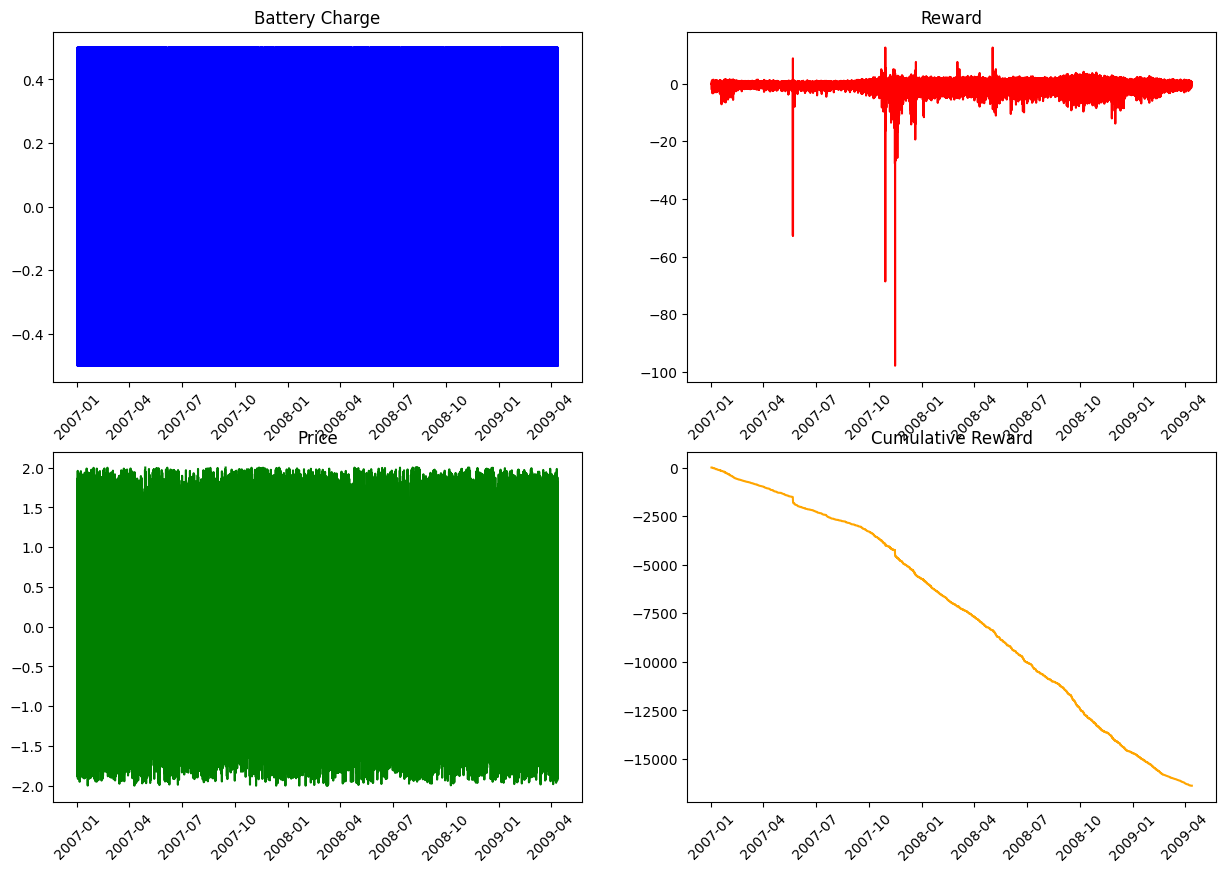

In [5]:
#Evaluate Rule Agent
price_horizon = 5
env = gym.make('gym_env/BatteryGrid-v0')
env.setup(train, price_horizon=price_horizon)
eval_rule = Evaluation(train, env, price_horizon=price_horizon)
eval_rule.rule_agent(iterations = 20000)
eval_rule.plot_single(normalize=False)

In [ ]:
## Questions for RL approach: 

# What is the state space? How far back do we need to look? Idea for now: For the first 96 time steps (4 days), we do nothing, until we gathered enough prices to make a decision. (Note: We will charge anyway ) Then, we look at the last 96 time steps and let the algorithm derive a strategy to act optimally based on that.
# Do we fill our replay buffer with random actions in the beginning?
# How do we handle the continous action space to update the output? We need to choose the max next action, but we can't do that with a continous action space. Think and inform about that. For now, we will use a discrete action space, evenly spaced.
# Important Decision: When and how do we normalize? Do we normalize once in the beginning, or do we normlaize every price history window separately? By doing so, we deprive the model of a "global" sense of price, although that might not be detrimental, as the price is mostly locally relevant. 

In [6]:
seed = 2705
rep = 1000000
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_decay = 99999
epsilon_min = 0.05
learning_rate = 1e-4
price_horizon = 64
future_horizon = 0
hidden_dim = 64
verbose = True

# Initialize Environment
env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon)

#Initialize DQN
agent = DDQNAgent(env_name = 'gym_env/BatteryGrid-v0', 
                  df = train, 
                  device = 'cpu', 
                  epsilon_decay = epsilon_decay, 
                  epsilon_start = epsilon, 
                  epsilon_end = epsilon_min, 
                  discount_rate = gamma, 
                  lr = learning_rate, 
                  buffer_size = 50000, 
                  price_horizon = price_horizon, 
                  hidden_dim=hidden_dim)
    
obs = env.reset()

episode_reward = 0
episode_loss = 0
episode_counter = 0

for i in tqdm(range(rep)):
    
    action = agent.choose_action(i, obs['tensor'], greedy = False)
    new_obs,r,t,info = env.step(action)

    # Fill replay buffer - THIS IS THE ONLY THING WE DO WITH THE CURRENT OBSERVATION - LEARNING IS FULLY PERFORMED FROM THE REPLAY BUFFER
    agent.replay_memory.add_data((obs['tensor'], action, r, t, new_obs['tensor']))
    
    #Update DQN
    loss = agent.optimize(batch_size)
    
    # Update values
    episode_reward += r
    episode_loss += loss
    
    # New observation
    obs = new_obs

    if t:
        obs = env.reset()
        episode_counter += 1
        print('Episode ', episode_counter, 'Reward: ', episode_reward, 'Loss: ', episode_loss)
        episode_loss = 0
        episode_reward = 0
            

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:213: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'numpy.float64'>
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarn

Episode  1 Reward:  -8445.791937499975 Loss:  3094.417419965379


  5%|▌         | 52549/1000000 [02:01<35:05, 450.09it/s]  

Episode  2 Reward:  -5762.337879500004 Loss:  2744.664903704077


  8%|▊         | 78765/1000000 [03:10<40:43, 376.97it/s]  

Episode  3 Reward:  -3727.619932500007 Loss:  2159.1287562372163


 11%|█         | 105020/1000000 [04:13<33:52, 440.23it/s] 

Episode  4 Reward:  -1736.544614499995 Loss:  1569.6635668068193


 13%|█▎        | 131284/1000000 [05:12<31:46, 455.71it/s]

Episode  5 Reward:  -1092.449584999998 Loss:  1074.687155968044


 16%|█▌        | 157521/1000000 [06:19<31:35, 444.45it/s]  

Episode  6 Reward:  -1034.8571534999996 Loss:  786.6025530984625


 18%|█▊        | 183723/1000000 [07:32<34:08, 398.55it/s]  

Episode  7 Reward:  -915.9357329999982 Loss:  767.0673293024302


 21%|██        | 209978/1000000 [08:39<29:44, 442.83it/s]  

Episode  8 Reward:  -958.7189335 Loss:  775.9549147072248


 24%|██▎       | 236217/1000000 [09:42<39:24, 323.05it/s]  

Episode  9 Reward:  -926.0162585000005 Loss:  777.1988558990415


 25%|██▌       | 252291/1000000 [10:21<30:42, 405.85it/s]  


KeyboardInterrupt: 

In [ ]:
# To Do: 
# Check DQN functionality
# Check how price is developing if battery isn't discharging when car is gone
# Check how DQN learns when it has access to future prices
# Clean up Notebook

In [68]:
for i in range(11):
    print("Action:", i, " Count:", train_eval.actions.count(i))

Action: 0  Count: 1
Action: 1  Count: 5
Action: 2  Count: 0
Action: 3  Count: 1
Action: 4  Count: 3
Action: 5  Count: 30
Action: 6  Count: 9
Action: 7  Count: 9
Action: 8  Count: 24
Action: 9  Count: 8
Action: 10  Count: 10


In [7]:
train_eval = Evaluation(train, env)
train_eval.ddqn_agent(agent = agent, iterations = 100000)
train_eval.plot_single(normalize=False)

UnboundLocalError: cannot access local variable 'obs' where it is not associated with a value

In [ ]:
val_eval = Evaluation(val, env)
val_eval.ddqn_agent(agent = agent, iterations = 1000000)
val_eval.plot_single(normalize=False)

In [ ]:
# Reward Shaping:

# when rewards are not sparse, a measure of the uncertainty on
# the value function can be used to guide exploration.



# Replay Buffer:

# Problem: Our RL problem is a sequential one with a fixed starting point and a fixed order where to move. Does this affect the validity of s,a,r,s' for the replay buffer?


In [ ]:
# Feature Engineering: 

# ⁠Gradient of curve 
# Value of to same date last year if available 
# ⁠Moving average on different scale
# ⁠⁠Moving standard deviation  on different scales 
# ⁠⁠Season
# ⁠Day of week
# ⁠⁠Month
# Average historic hourly price
# Hardcoded price boundary (sell when price at previous timestep above threshold, buy when price at previous timestep is below threshold) - this can be a dynamic boundary (per month, per day, …) or a hard boundary 


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import pickle
import pandas as pd
import numpy as np
import math
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()


    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)


    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels) # num_channels is a list of the number of channels for each layer 
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)


class TCNModel(nn.Module):
    def __init__(self, seq_len, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            num_inputs, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(seq_len*num_channels[-1], 3)

    def forward(self, x):
        tcn_output = self.tcn(x).flatten(end_dim = -2).t() #Flatten over the features and timestep dimensions, preserve batch dimension
        return self.dense(self.dropout(tcn_output))


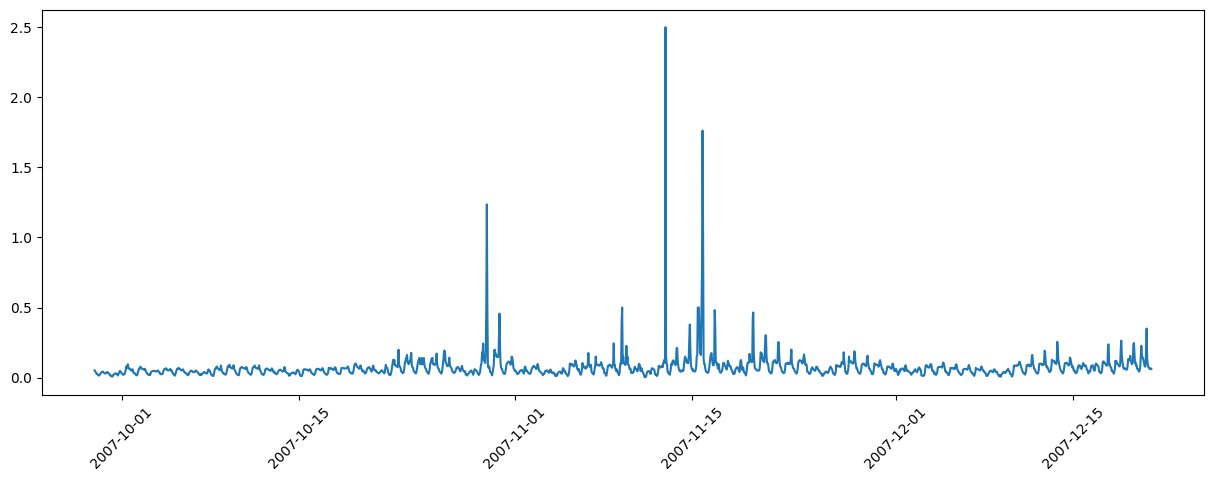

In [38]:
start = 6500
range = 2000
plt.figure(figsize=(15,5))
plt.plot(train['datetime'][start:(start+range)], train['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

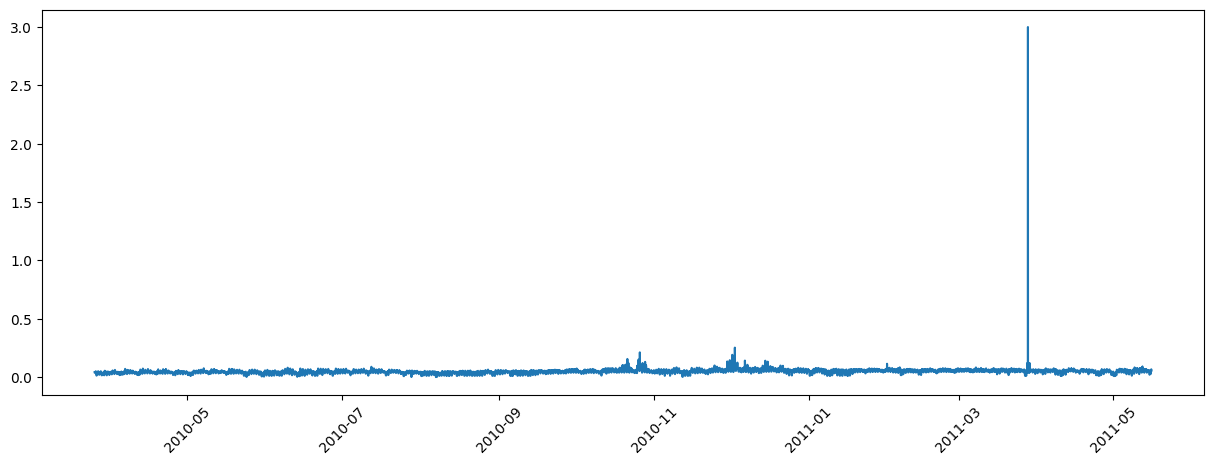

In [33]:
start = 2000
range = 10000
plt.figure(figsize=(15,5))
plt.plot(val['datetime'][start:(start+range)], val['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()